In [ ]:
from win32api import GetKeyState
from win32con import VK_NUMLOCK
import time

def wait_for_numlock():
    while True:
        numlock_state = GetKeyState(VK_NUMLOCK)
        if not numlock_state:
            time.sleep(1)
        else:
            break

print("numlock must be on to continue to next step")
for i in range(50):
    wait_for_numlock()
    %run dav_subtitle2.ipynb

In [1]:
import json
def get_cell(notebook_path, cell_number):
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook = json.load(f)
    
    code_cells = [cell for cell in notebook['cells']]
    
    if cell_number < 0 or cell_number >= len(code_cells):
        raise ValueError(f"Cell number must be between 0 and {len(code_cells) - 1}")
    
    return code_cells[cell_number]

def get_steps(notebook_path):
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook = json.load(f)
    
    # Find all cells with the marker comment
    marker_cells = []
    for i, cell in enumerate(notebook['cells']):
        if cell['cell_type'] == 'code' and cell['source']:
            if cell['source'][0].find("# comment: Automated step generated with pyPeriscope V2")>-1:
                marker_cells.append(i)
    
    if not marker_cells:
        return []
    
    # Create step ranges
    steps = []
    # First step: from start to first marker
    steps.append((0, marker_cells[0]-1))
    
    # Middle steps: between markers
    for i in range(len(marker_cells)-1):
        steps.append((marker_cells[i]-1, marker_cells[i+1]-1))
    
    # Last step: from last marker to end
    if marker_cells:
        steps.append((marker_cells[-1]-1, len(notebook['cells'])))

    # Make the 1st two into one as there are some imports in front
    steps = steps[1:]
    steps[0] = (0,steps[0][1])
    
    return steps

In [2]:
def view_cell(notebook_path, cell_number):
    code = get_cell(notebook_path, cell_number)
    if 'source' in code:
        if code['source'][0].find("# comment: Automated step") > -1:
            code['source'][1] = 'payload = \'*** removed for view ***\''
    if 'outputs' in code:
        if len(code['outputs']) > 0:
            code['outputs'] = ['*** removed for view ***']
    
    return(code)

In [3]:
from ipywidgets import widgets
from IPython.display import display as ipython_display
from PIL import Image
import io
import markdown

class Binoculars:
    def __init__(self, width=400):
        self.width = width
        self.image1 = None
        self.image2 = None
        self.box = None
        self._create_widgets()
        
    def _create_widgets(self):
        """Initialize all widgets including text areas"""
        # Create description text widget (Markdown)
        self.description = widgets.HTML(
            value='',
            placeholder='Description',
            description='',
        )
        
        # Create image widgets
        self.widget1 = widgets.Image(format='png', width=self.width)
        self.widget2 = widgets.Image(format='png', width=self.width)
        self.image_box = widgets.HBox([self.widget1, self.widget2])
        
        # Create error text widget (Markdown)
        self.error_text = widgets.HTML(
            value='',
            placeholder='Error messages',
            description='',
        )
        
        # Stack all widgets vertically
        self.box = widgets.VBox([
            self.description,
            self.image_box,
            self.error_text
        ])
        
        ipython_display(self.box)
        
    def _convert_to_bytes(self, pil_image):
        """Convert PIL image to bytes"""
        buf = io.BytesIO()
        pil_image.save(buf, format='PNG')
        return buf.getvalue()
    
    def update_image(self, image, position=1):
        """Update either the first or second image"""
        if not isinstance(image, Image.Image):
            raise TypeError("Input must be a PIL Image")
            
        image_bytes = self._convert_to_bytes(image)
        if position == 1:
            self.image1 = image
            self.widget1.value = image_bytes
        elif position == 2:
            self.image2 = image
            self.widget2.value = image_bytes
        else:
            raise ValueError("Position must be 1 or 2")
    
    def update_both(self, image1, image2):
        """Update both images at once"""
        self.update_image(image1, 1)
        self.update_image(image2, 2)
    
    def set_description(self, text):
        """Update description text with markdown formatting"""
        # Convert markdown to HTML
        md = markdown.Markdown()
        self.description.value = md.convert(text)
    
    def set_error(self, text):
        """Update error text with markdown formatting"""
        # Convert markdown to HTML with red color for errors
        md = markdown.Markdown()
        self.error_text.value = md.convert(text)
    
    def clear_texts(self):
        """Clear both description and error texts"""
        self.description.value = ''
        self.error_text.value = ''
    
    def get_current_images(self):
        """Return current PIL images"""
        return self.image1, self.image2

In [4]:
def run_code(code_str):
    current_globals = globals()  # Get fresh globals each time
    exec(code_str, current_globals)

# after every step record screenshot, last scope and last step
def StepRunner(worksheet, current_step, display_sys=None, stepsTotal=None):
    for active_step in range(get_steps(worksheet)[current_step][0], get_steps(worksheet)[current_step][1]):
        # Get current cell content
        current_cell = get_cell(worksheet, active_step)
        if not current_cell['cell_type'] == 'code':
            if display_sys:
                if current_cell['cell_type'] == 'markdown':
                    content = "".join(current_cell['source'])
                    if stepsTotal:
                        content = str(current_step)+"/"+str(stepsTotal) + "\n\n" + content
                    display_sys.set_description(content)
            continue
            
        current_code = "".join(current_cell['source'])
        # remove render preview
        code = current_code.replace("step.render_preview()\n","")
        
        # if step.find() is here run it in sepparate try and catch loop
        if code.find("step.find()") > -1:
            code = code.replace("step.find()","current = pyautogui.screenshot()")
            try:
                run_code("step.find()")
                if display_sys:
                    display_sys.update_image(step.render_preview(), position=1)
                    display_sys.update_image(step.draw_found(), position=2)
                continue
            except Exception as e:
                run_code(code) 
                if display_sys:
                    display_sys.update_image(step.render_preview(), position=1)
                    display_sys.update_image(current.crop(step.crop_box), position=2)
                    display_sys.set_error(str(e))
                else:
                    # Save the screenshot and metdata for the broken step
                    # TODO
                    print(e)
                return(-1*current_step-1)  
        # run the code
        try:
            run_code(code)
        except Exception as e:
            print(code)
            print(e)
    return(0)

In [5]:
def run_workbook(wb, display_sys=None, firstStep = -1):
    stepsIndexies = get_steps(wb)
    stepsTotal = len(stepsIndexies)

    # run all the steps in the workbook
    for step in range(0, stepsTotal):
        # if the workflow broke donw the continue from the last step
        if firstStep > 0:
            if firstStep == step:
                firstStep = -1
            else:
                continue
        # run the indivdual step
        if StepRunner(wb, step, display_sys, stepsTotal-1) == -1:
            return(-1)
    return(0)

In [6]:
display = Binoculars()

In [8]:
run_workbook("dav_subtitle2.ipynb", display, 0)

-1

In [20]:
from win32api import GetKeyState
from win32con import VK_NUMLOCK
import time

def wait_for_numlock():
    while True:
        numlock_state = GetKeyState(VK_NUMLOCK)
        if not numlock_state:
            time.sleep(1)
        else:
            break
last_step = -1;
print("numlock must be on to continue to next step")
for i in range(10):
    wait_for_numlock()
    last_step = run_workbook("dav_subtitle2.ipynb", display)
    if last_step < 0:
        print("stopped at: "+str(last_step*-1-1))
        break

numlock must be on to continue to next step
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1
found: 1


KeyboardInterrupt: 

In [106]:
StepRunner("dav_subtitle2.ipynb", 0, display)

0

In [36]:
display.set_description("## Test")

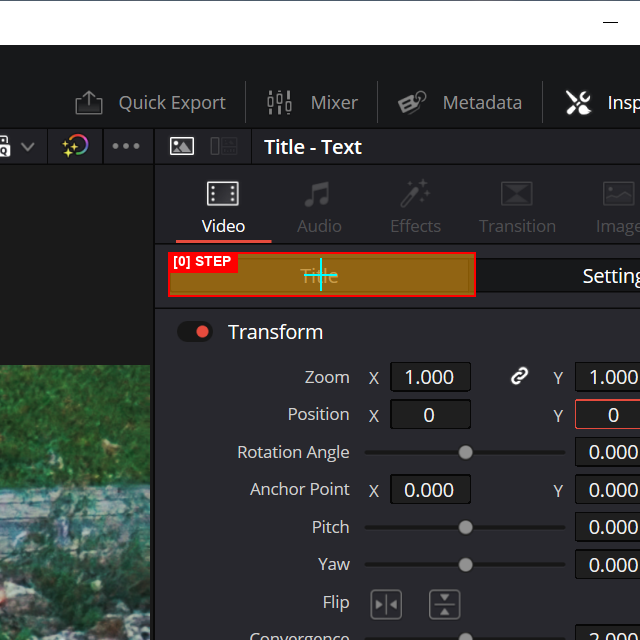

In [94]:
step.draw_found()